In [2]:
import calendar
import pandas as pd
import numpy as np
import io
import os
from pandas import read_csv
import numpy as np # linear algebra
import random as rd # generating random numbers
import datetime # manipulating date formats
import time
import ast
from math import sqrt
# Viz
import seaborn as sns # for prettier plots
import matplotlib.pyplot as plt
%matplotlib inline
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn; seaborn.set()
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import warnings
warnings.filterwarnings('ignore')
import json
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import performance_metrics
import utils

In [3]:
df=pd.read_csv("/bigdata/tara/ind_london_2018_sample.csv",index_col=0)
df.head()

,operator_id,bikes,spaces,total_docks,timestamp
11,12,13,36,49,2018-01-01 00:00:00
13,14,35,13,48,2018-01-01 00:00:00
16,17,19,7,26,2018-01-01 00:00:00
17,18,9,18,27,2018-01-01 00:00:00
30,32,19,24,43,2018-01-01 00:00:00


In [4]:
df_station=pd.read_csv('SampleData/sample_stations.csv',index_col=0)
df_station.head()

,ucl_id,operator_intid,operator_altid,operator_name,lat,lon,initial_bikes,initial_size,curr_bikes,curr_size,created_dt,updated_dt,neighbors_1,neighbors_2,station_id,change_count
0,12,12,12,"Malet Street, Bloomsbury",51.521681,-0.130432,25,40,26,49,2010-08-06 01:00:00,2020-02-14 17:38:02,"[364, 287]","[364, 287, 88, 19, 796]",12,38553
1,116,116,116,"Little Argyll Street, West End",51.514500,-0.141424,12,21,5,21,2010-08-06 01:00:00,2020-02-14 17:38:02,"[349, 159]","[159, 349, 313, 106, 141]",116,37611
3,32,32,32,"Leonard Circus , Shoreditch",51.524696,-0.084439,17,21,9,43,2010-08-06 01:00:00,2020-02-14 17:38:02,[323],"[323, 73, 58, 3, 319]",32,40529
6,195,195,195,"Milroy Walk, South Bank",51.507244,-0.106238,3,30,19,30,2010-08-06 01:00:00,2020-02-14 17:38:02,"[839, 230, 240, 792]","[839, 240, 230, 792, 420]",195,36805
7,66,66,66,"Holborn Circus, Holborn",51.517950,-0.108657,39,39,26,40,2010-08-06 01:00:00,2020-02-14 17:38:02,"[546, 67, 835]","[546, 67, 835, 84, 112]",66,49363


In [5]:
df_station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 0 to 65
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ucl_id          47 non-null     int64  
 1   operator_intid  47 non-null     int64  
 2   operator_altid  47 non-null     int64  
 3   operator_name   47 non-null     object 
 4   lat             47 non-null     float64
 5   lon             47 non-null     float64
 6   initial_bikes   47 non-null     int64  
 7   initial_size    47 non-null     int64  
 8   curr_bikes      47 non-null     int64  
 9   curr_size       47 non-null     int64  
 10  created_dt      47 non-null     object 
 11  updated_dt      47 non-null     object 
 12  neighbors_1     47 non-null     object 
 13  neighbors_2     47 non-null     object 
 14  station_id      47 non-null     int64  
 15  change_count    47 non-null     int64  
dtypes: float64(2), int64(9), object(5)
memory usage: 6.2+ KB


In [6]:
start_dates=['2018-01-01','2018-02-01','2018-03-01','2018-04-01','2018-05-01','2018-06-01','2018-07-01','2018-08-01',
             '2018-09-01','2018-10-01','2018-11-01','2018-12-01']
end_dates=['2018-01-31','2018-02-28','2018-03-31','2018-04-30','2018-05-31','2018-06-30','2018-07-31','2018-08-31'
           ,'2018-09-30','2018-10-31','2018-11-30','2018-12-31']


In [7]:
freq=10 #the original freq of data is 2 minutes interval
time_offset=60 #for how many minutes ahead we want to predict
#forecast_steps=int(time_offset/freq) #number of predictions that we need to predict time_offset ahead
test_days=7 #the number of days for test
test_size=int(test_days*24*60/freq) 
forecast_steps=int(time_offset/freq)
# window_size=int(24*60/freq)
window_size=int(4*60/freq)
Stations=list(df_station['ucl_id'])

In [8]:
xtest_size=984

In [9]:
def last_value(station_id):
    """Performs the Last Value method by rolling window"""
    global i

    forecasts=[]
    tests=[]
    history_df=df_train.copy()
    for t in range(0,len(df_test),window_size):
        result={}
        predictions = list()
        yhat=[history_df.iloc[-1].values] * window_size
        predictions.extend(yhat)
        history_df = history_df.append(df_test[t:t+window_size])
        
        df_forecast = pd.DataFrame(predictions, index=df_test.index[t:t+window_size], columns=df_train.columns + '_forecast_0')
        #print(type(yhat))
#         df_forecast= utils.forecast_truncate(df_forecast,total_dock)
#         df_forecast=utils.inverse_normalize(df_forecast,total_dock)

#         df_actual=utils.inverse_normalize(df_test,total_dock) 
        forecasts.extend(list(df_forecast.iloc[:,0].values))
        tests.extend(list(df_test.iloc[t:t+window_size,0].values))
    plt.figure(figsize=(15,5))
    plt.plot(original_data.iloc[0:len(original_data)-test_size,0].values)
    plt.plot([None for i in df_train.iloc[:,0].values] + [x for x in tests])
    plt.plot([None for i in df_train.iloc[:,0].values] + [x for x in forecasts])




#         if ((t+window_size)%(6*window_size) == 0):
#                 result['day']=df_forecast.index[1].dayofweek
#                 result['month']=df_forecast.index[1].month
#                 result['station_id']=station_id
#     #             result['predict']=list(df_forecast.iloc[:,0].values)
#     #             result['test']=list(df_test.iloc[t:t+window_size,0].values)
#                 result['predict']=forecasts
#                 result['test']=tests

#                 with open('report/test/LV/'+'lv_result_'+str(station_id)+'_'+str(i)+'.json', 'w+') as f:
#                 #with open('report/LV/'+str(freq)+'minutes/lv_result_'+str(station_id)+'_'+str(i)+'.json', 'w+') as f:
#                     f.write(json.dumps(result))

#                 i=i+1
#                 forecasts=[]
#                 tests=[]


2018-05-01


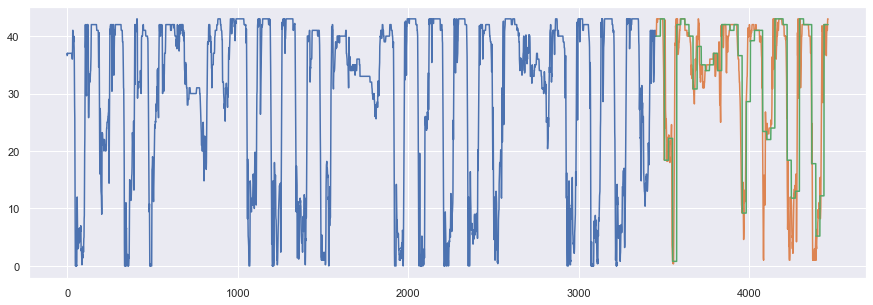

In [10]:
i=0
for t in range(4,5):
  
    start_date=start_dates[t]
    end_date=end_dates[t]        
    print(start_date)
    for station_id in [427]:
        
        
        
        total_dock=df[df['operator_id']==int(station_id)]['total_docks'].values[0]
        data=df[df['operator_id']==station_id]
        #data prepration       
        
        data=utils.clean_df(data,station_id,start_date,end_date,freq)
        original_data=data
        #data=utils.normalize(data,total_dock)
        #anomalies=utils.anomaly_detection(data,freq)
        #data=utils.anomaly_removal(anomalies,data)
        df_train, df_test = data[0:len(data)-test_size], data[len(data)-test_size:]
        
        #checking for stationarity
        #df_temp,d=utils.make_Stationary(df_train)
        #apply the model and get the result
        last_value(station_id)




In [11]:
def historical_average(station_id):
    """Performs the Last Value method by rolling window"""
    global i

    forecasts=[]
    tests=[]
    history_df=df_train.copy()
    for t in range(0,len(df_test),window_size):
        result={}
        predictions = list()
        yhat=[history_df[-len(df_train):].mean().values]* window_size       
        predictions.extend(yhat)
        history_df = history_df.append(df_test[t:t+window_size])
        
        df_forecast = pd.DataFrame(predictions, index=df_test.index[t:t+window_size], columns=df_train.columns + '_forecast_0')
        forecasts.extend(list(df_forecast.iloc[:,0].values))
        tests.extend(list(df_test.iloc[t:t+window_size,0].values))
    plt.figure(figsize=(15,5))
    plt.plot(original_data.iloc[0:len(original_data)-test_size,0].values)
    plt.plot([None for i in df_train.iloc[:,0].values] + [x for x in tests])
    plt.plot([None for i in df_train.iloc[:,0].values] + [x for x in forecasts])

#         if ((t+window_size)%(6*window_size) == 0):
#                 result['day']=df_forecast.index[1].dayofweek
#                 result['month']=df_forecast.index[1].month
#                 result['station_id']=station_id
#     #             result['predict']=list(df_forecast.iloc[:,0].values)
#     #             result['test']=list(df_test.iloc[t:t+window_size,0].values)
#                 result['predict']=forecasts
#                 result['test']=tests

#                 with open('report/test/HA/'+'lv_result_'+str(station_id)+'_'+str(i)+'.json', 'w+') as f:
#                 #with open('report/LV/'+str(freq)+'minutes/lv_result_'+str(station_id)+'_'+str(i)+'.json', 'w+') as f:
#                     f.write(json.dumps(result))

#                 i=i+1
#                 forecasts=[]
#                 tests=[]


2018-05-01


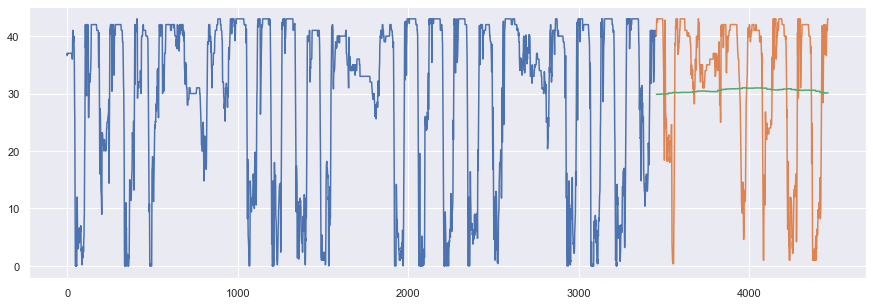

In [12]:
start=time.time()

i=0
for t in range(4,5):
  
    start_date=start_dates[t]
    end_date=end_dates[t]        
    print(start_date)
    for station_id in [427]:
        
        
        
        total_dock=df[df['operator_id']==int(station_id)]['total_docks'].values[0]
        data=df[df['operator_id']==station_id]
        #data prepration       
        
        data=utils.clean_df(data,station_id,start_date,end_date,freq)
        original_data=data
        #data=utils.normalize(data,total_dock)
        #anomalies=utils.anomaly_detection(data,freq)
        #data=utils.anomaly_removal(anomalies,data)
        df_train, df_test = data[0:len(data)-test_size], data[len(data)-test_size:]
        
        #checking for stationarity
        #df_temp,d=utils.make_Stationary(df_train)
        #apply the model and get the result
        historical_average(station_id)



end=time.time()